1.Configuración del ambiente

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import datetime 

2.Obtención de Datos

Precios históricos del bitcoin

In [8]:
# La biblioteca yfinance de Python permite extraer datos financieros de Yahoo Finance.

def importar_base_bitcoin():
  global df_bitcoin
  data = yf.Ticker("BTC-USD").history(period='7d', interval='5m')
  df_bitcoin = pd.DataFrame(data)
  return df_bitcoin

importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-12 00:00:00+00:00,26873.292969,26873.292969,26851.644531,26851.644531,0,0.0,0.0
2023-10-12 00:05:00+00:00,26847.873047,26879.015625,26847.873047,26879.015625,21223424,0.0,0.0
2023-10-12 00:10:00+00:00,26868.398438,26868.398438,26837.501953,26837.501953,11906048,0.0,0.0
2023-10-12 00:15:00+00:00,26836.802734,26852.451172,26836.564453,26836.564453,8825856,0.0,0.0
2023-10-12 00:20:00+00:00,26834.787109,26838.693359,26823.626953,26823.626953,7206912,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-17 20:05:00+00:00,28529.396484,28529.396484,28497.494141,28503.230469,0,0.0,0.0
2023-10-17 20:10:00+00:00,28508.312500,28526.031250,28506.576172,28526.031250,23351296,0.0,0.0
2023-10-18 00:00:00+00:00,28413.531250,28413.531250,28402.759766,28406.582031,0,0.0,0.0


Indicadores de tendencias

In [9]:
def extraer_tendencias():
    global precio_actual,tendencia
    url = 'https://coinmarketcap.com/'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    precio_btc = soup.find('div', class_='sc-a0353bbc-0 gDrtaY').get_text()
    precio_btc = precio_btc.replace(',', '')
    precio_btc = precio_btc.replace('$', '')
    precio_actual = float(precio_btc)
    icon = soup.findAll('span', {'class':['sc-d55c02b-0 iwhBxy','sc-97d6d2ca-0 bQjSqS']})[0]
    if 'sc-d55c02b-0 iwhBxy' in ' '.join(icon['class']):
        tendencia = 'alta'
    else:
        tendencia = 'baja'
    variacion = soup.find('span', class_='sc-d55c02b-0 iwhBxy').get_text()
    return [precio_actual, tendencia, variacion]

extraer_tendencias()

[28437.59, 'alta', '3.79%']

3.Limpieza de datos

In [10]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  df_bitcoin_limpio = df.copy()
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= Q1) & (close < Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return [df_bitcoin_limpio, Q1, Q3]

limpieza_datos()

[                                   Open          High           Low  \
 Datetime                                                              
 2023-10-12 00:05:00+00:00  26847.873047  26879.015625  26847.873047   
 2023-10-12 02:50:00+00:00  26889.494141  26914.347656  26885.308594   
 2023-10-12 02:55:00+00:00  26921.439453  26921.439453  26903.917969   
 2023-10-12 06:30:00+00:00  26881.158203  26883.787109  26878.732422   
 2023-10-12 06:35:00+00:00  26886.658203  26905.603516  26886.658203   
 ...                                 ...           ...           ...   
 2023-10-16 14:00:00+00:00  28002.537109  28092.332031  28002.537109   
 2023-10-16 14:05:00+00:00  28048.437500  28048.437500  27907.781250   
 2023-10-16 14:10:00+00:00  27914.875000  28021.923828  27914.875000   
 2023-10-16 14:15:00+00:00  27974.128906  28061.785156  27974.128906   
 2023-10-16 15:40:00+00:00  28094.236328  28094.236328  28050.218750   
 
                                   Close     Volume  Dividends

In [11]:
df_new = pd.DataFrame(df_bitcoin_limpio)

In [12]:
df_new

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-12 00:05:00+00:00,26847.873047,26879.015625,26847.873047,26879.015625,21223424,0.0,0.0
2023-10-12 02:50:00+00:00,26889.494141,26914.347656,26885.308594,26911.187500,1995776,0.0,0.0
2023-10-12 02:55:00+00:00,26921.439453,26921.439453,26903.917969,26903.917969,24152064,0.0,0.0
2023-10-12 06:30:00+00:00,26881.158203,26883.787109,26878.732422,26883.242188,5196800,0.0,0.0
2023-10-12 06:35:00+00:00,26886.658203,26905.603516,26886.658203,26899.298828,19343360,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-16 14:00:00+00:00,28002.537109,28092.332031,28002.537109,28011.207031,560906240,0.0,0.0
2023-10-16 14:05:00+00:00,28048.437500,28048.437500,27907.781250,27907.781250,225536000,0.0,0.0
2023-10-16 14:10:00+00:00,27914.875000,28021.923828,27914.875000,27969.931641,255469568,0.0,0.0


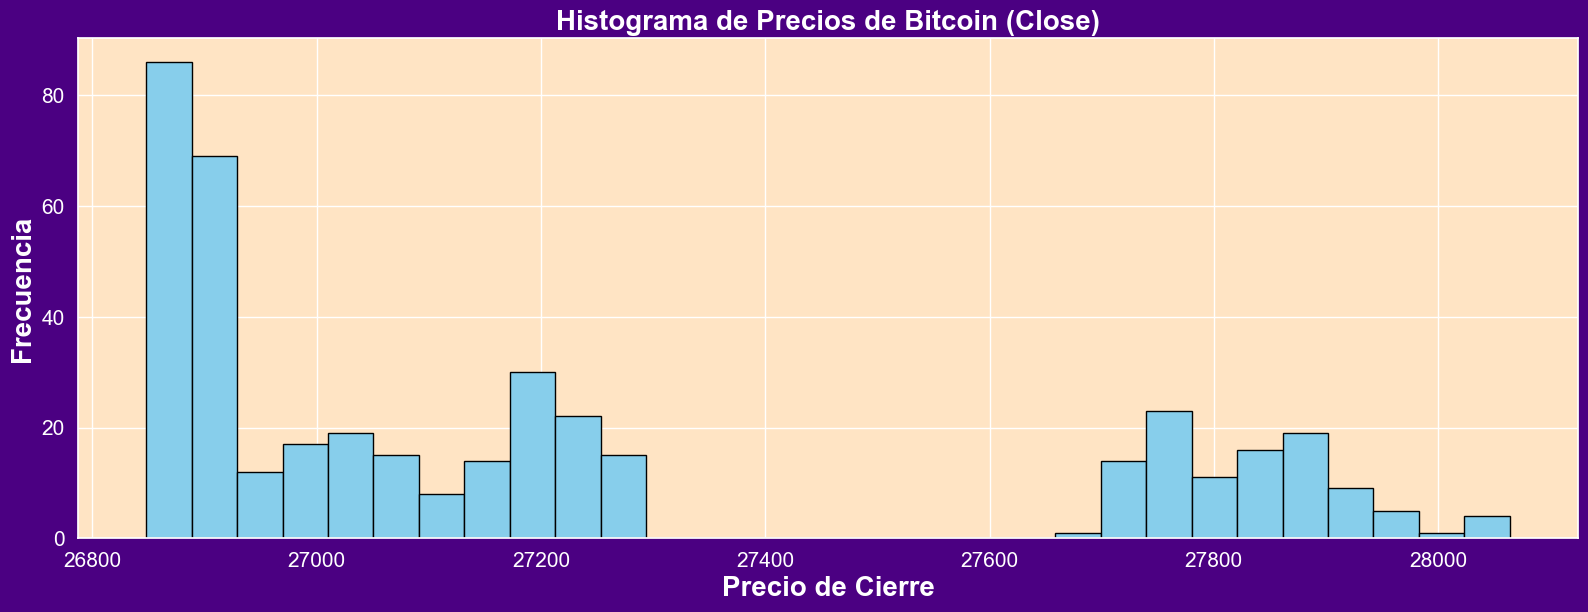

In [13]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.hist(close, bins=30, color='skyblue', edgecolor='black')
eje.set_title('Histograma de Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.show()


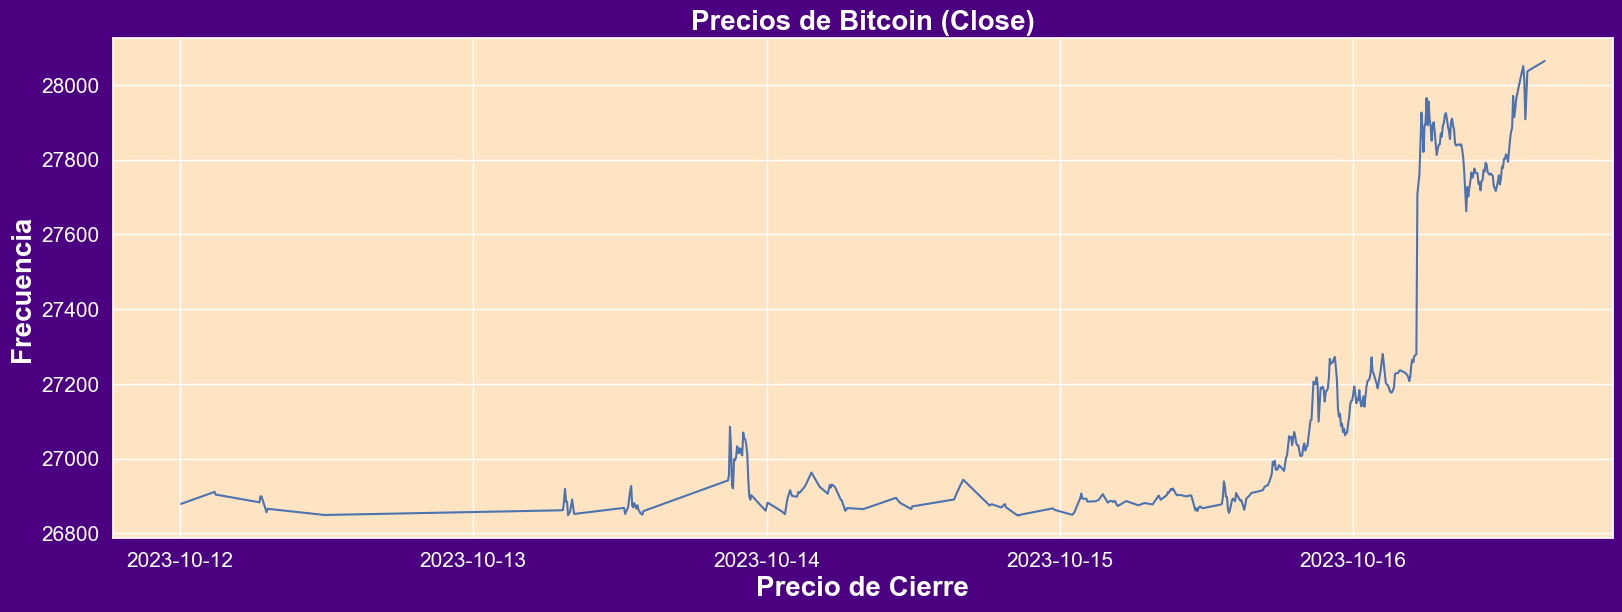

In [14]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.plot(close)
eje.set_title('Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.show()

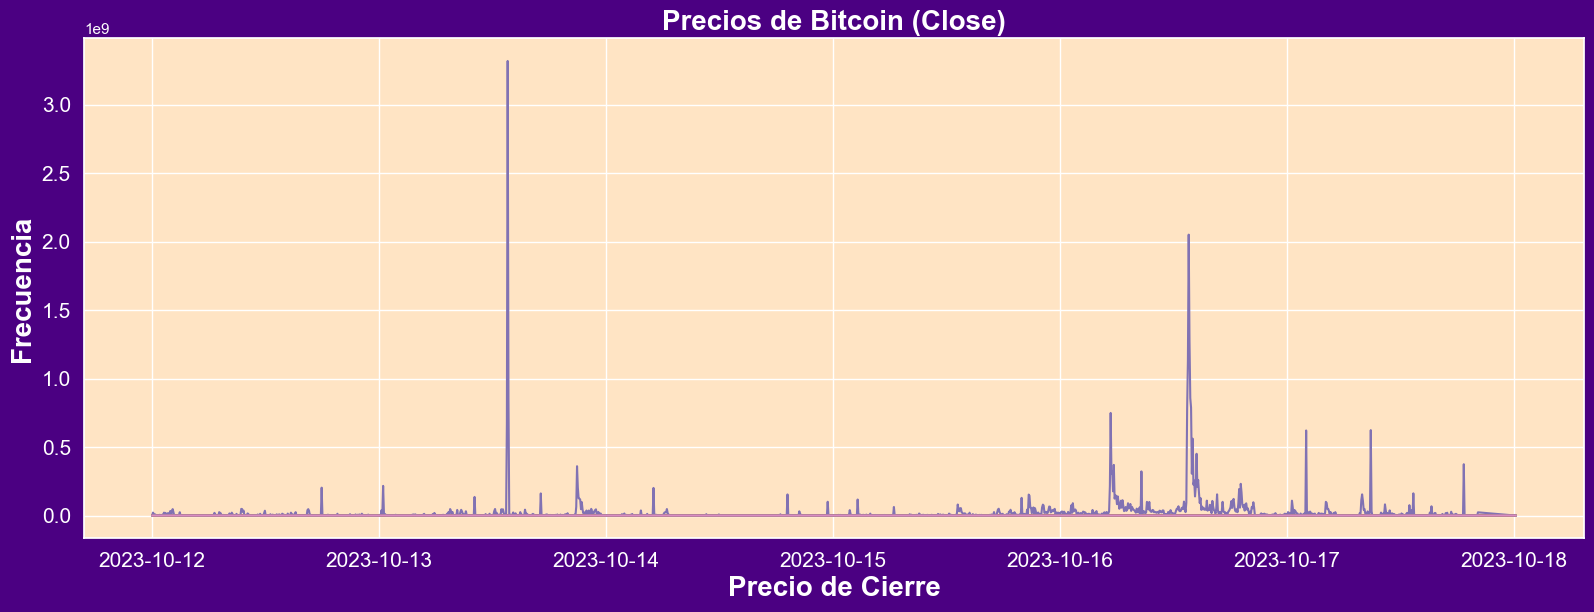

In [15]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(15,5), facecolor='indigo')
eje = fig.add_axes([0,0,1,1])
eje.tick_params(axis='x', colors='w', labelsize=15)
eje.tick_params(axis='y', colors='w', labelsize=15)

datos_limpios = limpieza_datos()[0]
close = datos_limpios['Close']

eje.plot(df_bitcoin)
eje.set_title('Precios de Bitcoin (Close)', fontsize=20, fontweight='bold', color='w')
eje.set_xlabel('Precio de Cierre', fontsize=20, fontweight='bold', color='w')
eje.set_ylabel('Frecuencia', fontsize=20, fontweight='bold', color='w')
eje.set_facecolor('bisque')
plt.show()

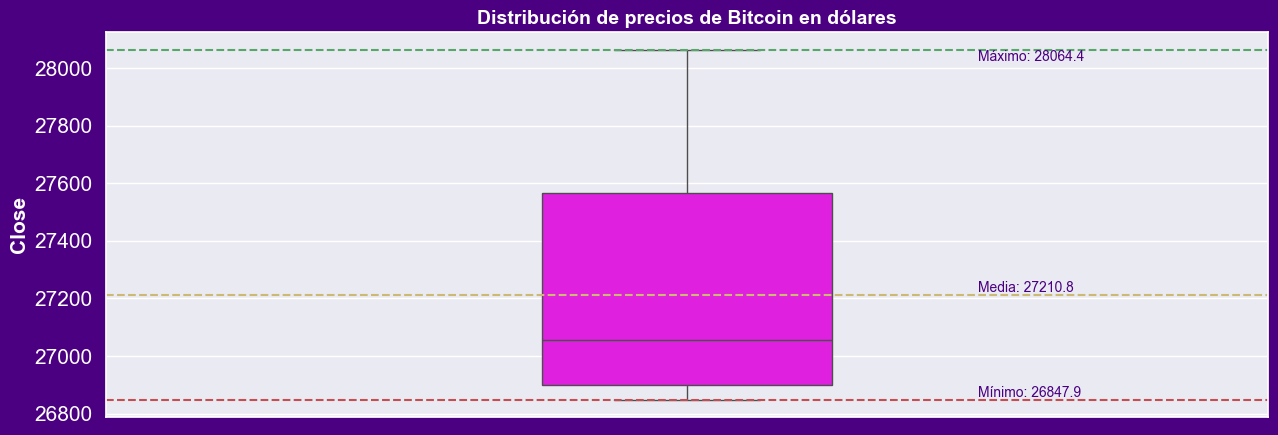

In [16]:
def boxplot1():
  sns.set(style="darkgrid")
  plt.figure(figsize=(15, 5), facecolor='indigo')
  plt.tick_params(axis='x', colors='w', labelsize=15)
  plt.tick_params(axis='y', colors='w', labelsize=15)
 
  boxplot = sns.boxplot(y='Close', data=df_bitcoin_limpio, color='magenta', whis=2, width=0.25)
  plt.ylabel('Close', fontsize=15, color='w', fontweight='bold')
  plt.title('Distribución de precios de Bitcoin en dólares', fontsize=14, color='w',fontweight='bold')

  media = df_bitcoin_limpio['Close'].mean()
  maximo = limpieza_datos()[2]
  minimo = limpieza_datos()[1]

  boxplot.axhline(y=maximo, color='g', linestyle='--')
  boxplot.axhline(y=media, color='y', linestyle='--') 
  boxplot.axhline(y=minimo, color='r', linestyle='--') 
  
  plt.text(x=0.25, y=limpieza_datos()[2], s=f'Máximo: {limpieza_datos()[2].round(1)}', fontsize=10, va='top', color='indigo')
  plt.text(x=0.25, y=media, s=f'Media: {media.round(1)}', fontsize=10, va='bottom', color='indigo')
  plt.text(x=0.25, y=limpieza_datos()[1], s=f'Mínimo: {limpieza_datos()[1].round(1)}', fontsize=10, va='bottom', color='indigo')
  return plt.show()

boxplot1()

4.Toma de desición Compra / Vanta / Espera

In [17]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender--'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar--'
  else:
    algoritmo_decision = 'Esperar--'

  return algoritmo_decision

tomar_decisiones()

'Esperar--'

5.Visualizando los datos / Variación de los últimos 7 días

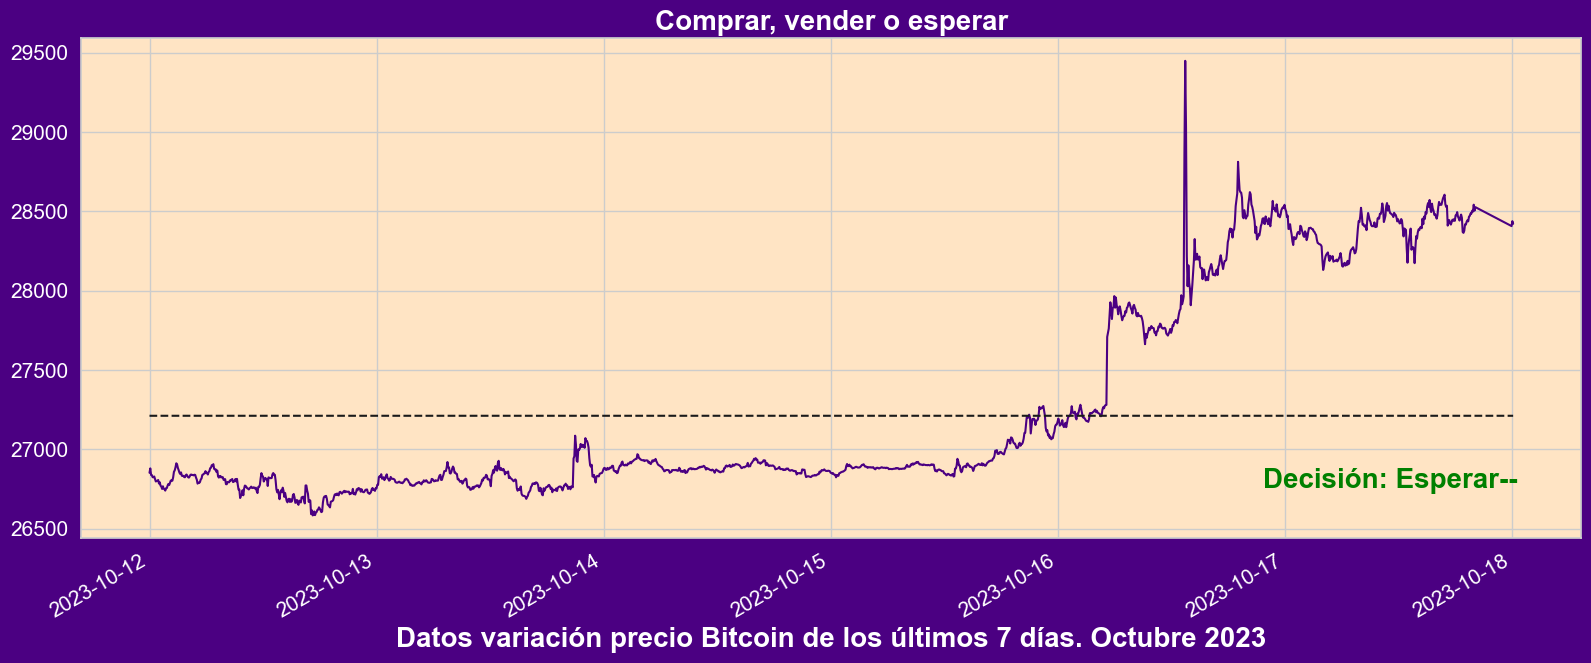

In [18]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin

  sns.set(style="whitegrid")
  fig = plt.figure(figsize=(15,5), facecolor='indigo')
  eje = fig.add_axes([0,0,1,1])
  eje.tick_params(axis='x', colors='w', labelsize=15)
  eje.tick_params(axis='y', colors='w', labelsize=15)
  
  eje.set_title('Comprar, vender o esperar', fontsize=20,fontweight='bold', color='w')
  df_bitcoin['Close'].plot(legend = None, color = 'indigo')
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = 'k', fontsize=15)
  

  eje.set_xlabel('Datos variación precio Bitcoin de los últimos 7 días. Octubre 2023', fontsize=20, fontweight='bold', color='w')
  eje.set_facecolor('bisque')
  eje.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-180, -190), textcoords='offset points', fontsize=20, color='green',fontweight='bold')
  plt.show()
  
visualizacion()

6.Automatizamos el sistema 

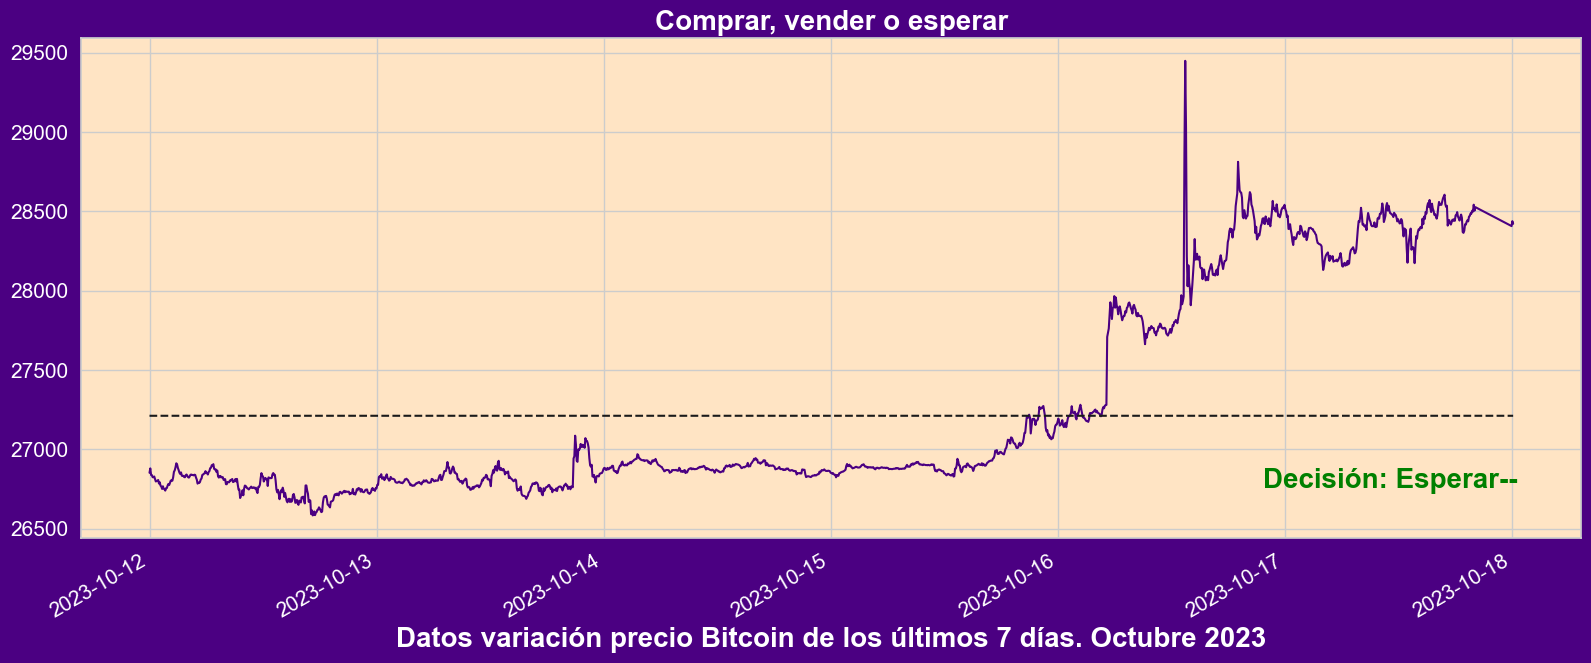

In [19]:
while True:
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)


La toma de datos de variación de precio del bitcoin de los últimos 7 días es un proceso que consiste en recopilar información sobre el precio del bitcoin en un período de tiempo determinado. Esta información se puede utilizar para realizar análisis de tendencias y proyecciones del precio futuro de la moneda.
En nuestro caso para la toma de desiciones de Compra / Venta / Espera según situación y conveniencia.
Web scraping: Este método permite extraer datos de una página web utilizando un script o programa.
Una vez que se han recopilado los datos, se pueden almacenar en una base de datos o en un archivo CSV. Los datos se pueden analizar utilizando una variedad de herramientas y técnicas, como hojas de cálculo, software de análisis de datos y lenguajes de programación.
Una vez que se han recopilado los datos, se pueden analizar para obtener información sobre la variación de precio del bitcoin de los últimos 7 días. Por ejemplo, se puede calcular el rendimiento diario del bitcoin o el porcentaje de variación de precio del bitcoin en un período de tiempo determinado.